# Класифікація зображень згортковими нейронними мережами.

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Завантаження даних.

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 33180431.62it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 87779488.28it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11653587.45it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14894862.21it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Створення моделі.
Згорткові шари:<br><br>

Перший згортковий шар: 1 вхідний канал, 6 вихідних з отримання властивостей, вказуємо розмір ядра 3 та розмір кроку 1;<br>
Другий згортковий шар: 6 вхідних каналів з попереднього шару, 16 вихідних, детектор ознак має аналогічні параметри;<br>
<br>
Вхідний розмір першого шару розрахований наступним чином: 3x3 фільтр, застосований до зображення
28х28 залишає край з усіх сторін розміром 1 піксель. За один шар розмір зображення змінюється з 28х28 до 26х26. Оскільки ядро
застосовується двічі, розмір зображення буде: (((28−2)/2)−2)/2=5.5, що буде округлено до 5.

In [ ]:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [5]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [7]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Створення оптимізатора та функції втрат.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Тренування моделі.

In [9]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')          

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04255062  accuracy:  78.483%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08127413  accuracy:  85.825%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.31574458  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02466622  accuracy:  90.479%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00694099  accuracy:  91.620%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00119799  accuracy:  92.456%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.48073339  accuracy:  93.105%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02856708  accuracy:  93.585%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00612010  accuracy:  93.996%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.04120112  accuracy:  94.315%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.03120892  accuracy:  97.817%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.04176106  accuracy:  97.825%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00131547  accuracy:  97.872%
epoch:  1  b

## Оцінка моделі.

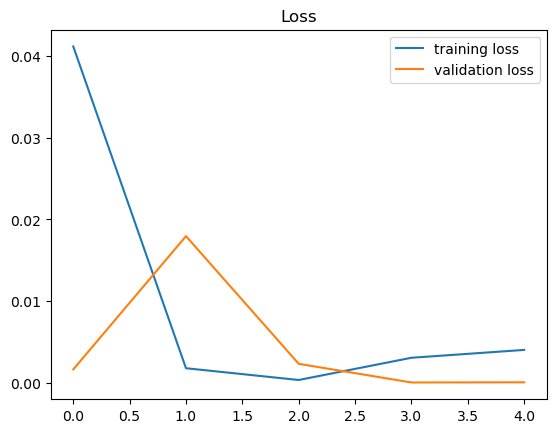

In [10]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss')
    plt.legend();

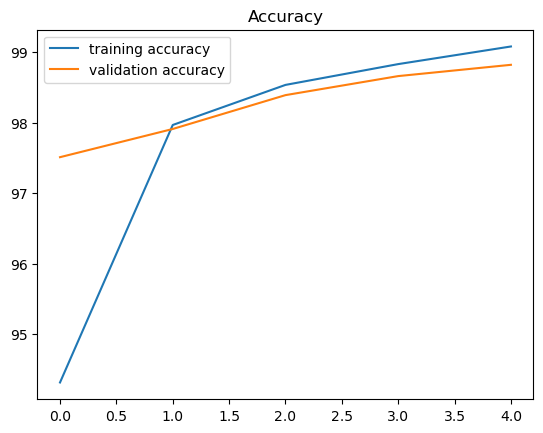

In [11]:
with torch.no_grad():
    plt.plot([t/600 for t in train_correct], label='training accuracy')
    plt.plot([t/100 for t in test_correct], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend();

In [12]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9882/10000 =  98.820%


In [13]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    0    0    0    2    3    0    3    0]
 [   0 1132    0    1    0    0    3    5    0    2]
 [   4    0 1027    2    0    0    1    7    1    0]
 [   0    3    0 1002    0   12    0    0    4    0]
 [   0    0    1    0  980    1    4    1    1   12]
 [   0    0    0    1    0  869    1    0    0    3]
 [   2    0    0    0    0    2  944    0    0    0]
 [   1    0    2    1    0    1    0 1009    2    3]
 [   1    0    2    2    0    0    2    2  961    3]
 [   0    0    0    1    2    5    0    4    2  986]]


In [14]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
len(misses)

118

In [15]:
r = 12
row = iter(np.array_split(misses,len(misses)//r+1))

Індекс: [ 320  340  359  412  445  460  582  674  947  951 1014 1039]
Значення: [   9    5    9    5    6    5    8    5    8    5    6    7]
Передбачення: [   8    3    4    3    0    9    2    3    9    4    5    1]


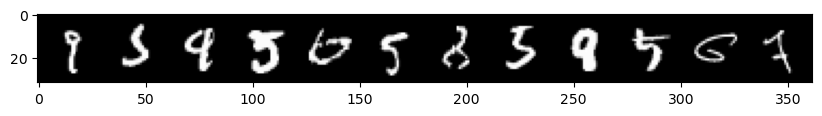

In [16]:
nextrow = next(row)
print("Індекс:", nextrow)
print("Значення:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Передбачення:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));